<a href="https://colab.research.google.com/github/daniel-falk/ai-ml-principles-exercises/blob/colab/ML-training/activeloop-deeplake/predict_weather_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deeplake

import tensorflow as tf
import numpy as np
import deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def preprocess_sample(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 240, 320)
  image = tf.math.reduce_mean(image, axis=2, keepdims=False)
  image = image / 128 - 1
  return image, label 


hub_ds = deeplake.load("hub://kingabzpro/muticlass-weather-dataset")
tf_ds = (hub_ds.tensorflow(tensors=["images", "labels"])
               .map(lambda d: (d["images"], d["labels"]))
               .map(preprocess_sample)
)

hub://kingabzpro/muticlass-weather-dataset loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/kingabzpro/muticlass-weather-dataset


/usr/local/lib/python3.7/dist-packages/deeplake/core/tensor.py:599: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  "Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead."


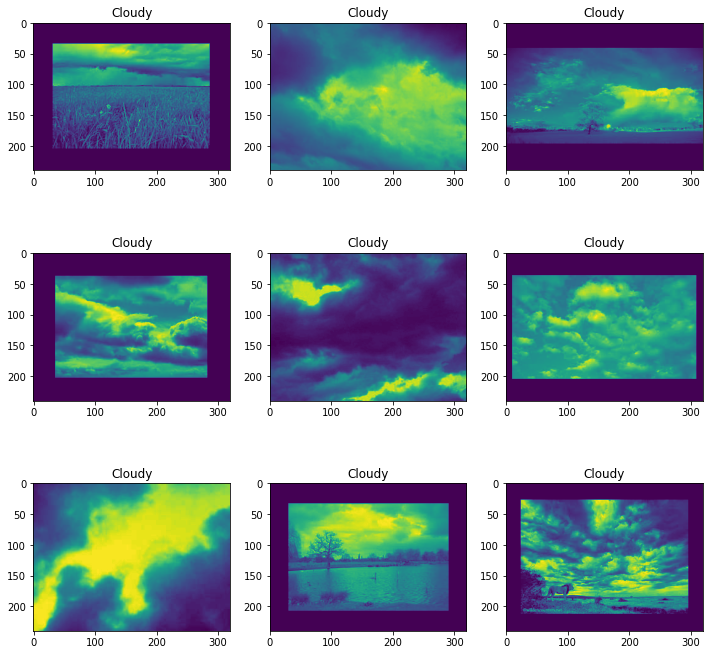

CPU times: user 1.51 s, sys: 60 ms, total: 1.57 s
Wall time: 2.01 s


In [3]:
%%time

import matplotlib.pyplot as plt

images, labels = next(iter(tf_ds.take(9).batch(9)))
images = [img.numpy() for img in images]

_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for image, label, ax in zip(images, labels, axs):
  ax.imshow(image)
  ax.set_title(hub_ds.labels.info.class_names[label[0].numpy()])
plt.show()

In [4]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(240, 320)),
  tf.keras.layers.Reshape(target_shape=(240, 320, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(hub_ds.labels.info.class_names))
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

tf_ds_tmp = tf_ds.shuffle(len(hub_ds)).batch(64)
tf_ds_valid = tf_ds_tmp.take(1)  # One batch for validation
tf_ds_train = tf_ds_tmp.skip(1)

In [5]:
%%time

model.fit(
  tf_ds_train,
  epochs=5,
  validation_data=tf_ds_valid
)

Epoch 1/5
17/17 [==============================] - 111s 5s/step - loss: 1.3928 - accuracy: 0.4439 - val_loss: 0.8516 - val_accuracy: 0.5938
Epoch 2/5
17/17 [==============================] - 88s 4s/step - loss: 0.8753 - accuracy: 0.6315 - val_loss: 0.7322 - val_accuracy: 0.6719
Epoch 3/5
17/17 [==============================] - 88s 4s/step - loss: 0.7326 - accuracy: 0.6975 - val_loss: 0.6428 - val_accuracy: 0.8281
Epoch 4/5
17/17 [==============================] - 89s 4s/step - loss: 0.6174 - accuracy: 0.7644 - val_loss: 0.5176 - val_accuracy: 0.8125
Epoch 5/5
17/17 [==============================] - 88s 4s/step - loss: 0.5336 - accuracy: 0.7974 - val_loss: 0.4301 - val_accuracy: 0.9062
CPU times: user 9min 23s, sys: 8.39 s, total: 9min 32s
Wall time: 9min 31s


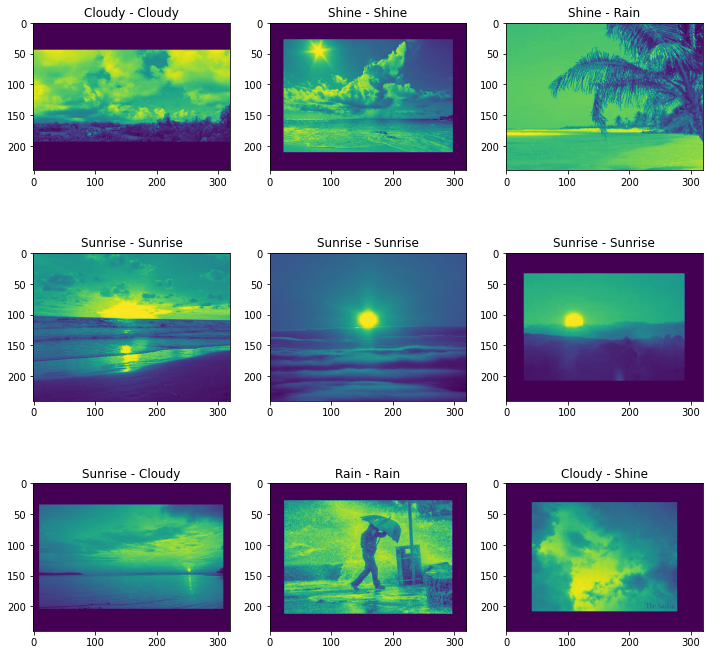

In [6]:
images, labels = next(iter(tf_ds_valid.unbatch().take(9).batch(9)))
images = [img.numpy() for img in images]

_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for image, label, ax in zip(images, labels, axs):
  true_class = label[0].numpy()
  pred_class = np.argmax(model(image[None]))
  title = f"{hub_ds.labels.info.class_names[true_class]} - {hub_ds.labels.info.class_names[pred_class]}"
  ax.imshow(image)
  ax.set_title(title)
plt.show()